# Preparation

## Import of the libraries

In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import mutual_info_regression as mutual_info
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import SVR
import math

## Loading and preprocessing of the data

We load the different datasets and we check that there is not any missing value and that the two datasets have the same size.
Then we add the embeddings to the main dataset.

In [280]:
# The datasets for building and testing the model
df_smurfs = pd.read_csv("./data/Xtab1.csv")
df_predictions = pd.read_csv("./data/Y1.csv", header=None)
df_img_embeddings = pd.read_csv("./data/Ximg1.csv")

# The datasets for producing our predictions
df_smurfs_unknown = pd.read_csv("./data/Xtab2.csv")
df_img_embeddings_unknown = pd.read_csv("./data/Ximg2.csv")

df_smurfs.info()
df_smurfs.head()
#df_predictions.head()
#df_img_embeddings.head()

# We look at the missing values
print(df_smurfs.isnull().any())
print(df_img_embeddings.isnull().any())

# We add the images embedding to our smurf dataset
df_smurfs = df_smurfs.merge(df_img_embeddings, on="img_filename", how="left")
df_smurfs = df_smurfs.drop("img_filename", axis=1)
# We check that the result of the merge has the expected shape
print("The shape of the transformed dataframe is : ", df_smurfs.shape)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                800 non-null    int64  
 1   blood pressure     800 non-null    float64
 2   blood type         800 non-null    object 
 3   cholesterol        800 non-null    float64
 4   hemoglobin         800 non-null    float64
 5   physical activity  800 non-null    object 
 6   sarsaparilla       800 non-null    object 
 7   smurfberry liquor  800 non-null    object 
 8   smurfin donuts     800 non-null    object 
 9   temperature        800 non-null    float64
 10  testosterone       800 non-null    float64
 11  weight             800 non-null    float64
 12  img_filename       800 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 81.4+ KB
age                  False
blood pressure       False
blood type           False
cholesterol          False
hemo

# Data Preprocessing

We have to treat the categorical data. Some of them can be ordered this is the reason why we use ordinal encoding. For instance the level of consumption ranges from 0 for very low consumption to 4 for very high consumption. The encoding of the blood type is totally arbitrary given that there is no relationship between the different groups.

In [281]:
# We adapt categorical variables with numerical labels
categorical_columns = ["physical activity", "sarsaparilla", "smurfberry liquor", "smurfin donuts", "blood type"]
replace_map = {"No": 0, "Very low": 0, "O-": 0, "Yes": 1, "Low": 1, "O+": 1, "Moderate": 2,
               "AB+": 2, "High": 3, "AB-": 3, "Very high": 4, "A+": 4, "A-": 5, "B+": 6, "B-": 7}
for col in categorical_columns:
    df_smurfs[col] = df_smurfs[col].replace(replace_map)


Let's look at the outliers. We will check if there are extrem values in the dataset. The statement let us assumes that there is no measure error in the dataset. We proceed very carefully here because the outliers can bring lots of information to the model if there are no measure errors. 

In [282]:
df_smurfs.describe(percentiles=[0.05, 0.95])
#print(df_smurfs["testosterone"].sort_values()[:20])

,age,blood pressure,blood type,cholesterol,hemoglobin,physical activity,sarsaparilla,smurfberry liquor,smurfin donuts,temperature,testosterone,weight,h1,h2,h3,h4,h5,h6,h7,h8
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,130.833750,97.514162,2.940000,109.846100,14.209737,0.545000,1.386250,2.237500,2.487500,37.004325,730.344775,102.040325,-0.370976,0.078378,-0.415801,0.405210,0.253208,-0.268859,0.174954,-0.253636
std,51.057121,11.703129,1.994084,26.793242,0.978690,0.498282,1.216104,1.141369,1.264651,0.503774,266.204288,13.695318,0.031431,0.029292,0.041881,0.034345,0.042581,0.038377,0.029358,0.060983
min,20.000000,51.230000,0.000000,40.350000,11.260000,0.000000,0.000000,0.000000,0.000000,35.750000,50.000000,58.160000,-0.476663,0.004997,-0.563539,0.340089,0.179231,-0.381955,0.111091,-0.423687
5%,47.950000,81.918500,0.000000,67.726500,12.639000,0.000000,0.000000,0.000000,0.000000,36.180000,272.954000,80.202500,-0.429662,0.034025,-0.496569,0.360050,0.200496,-0.337534,0.137428,-0.364960
50%,131.500000,95.560000,4.000000,108.780000,14.190000,1.000000,1.000000,2.000000,3.000000,37.000000,726.285000,101.820000,-0.367222,0.076238,-0.406837,0.399853,0.242204,-0.264544,0.169084,-0.250947
95%,216.050000,117.424000,6.000000,155.783000,15.880500,1.000000,4.000000,4.000000,4.000000,37.820000,1165.460500,125.500500,-0.327169,0.131912,-0.363793,0.471536,0.339549,-0.215741,0.230708,-0.169289
max,293.000000,178.310000,7.000000,189.180000,17.120000,1.000000,4.000000,4.000000,4.000000,38.550000,1568.240000,157.680000,-0.276375,0.166099,-0.333544,0.518287,0.407305,-0.163310,0.285407,-0.132603


We can notice that there are extreme values but nothing seems totally incoherent. Indeed the main outliers are the minimum for the age (that is not something weird here) and the minimum of testosterone concentration but there are several low values for this category so this is not an isolated outlier.

We will now split our data in 2 datasets to form our learning set (which will contain the training set and the test set) and our validation set.

Finally we will also standardize our data but it will be done each time we split the learning set. It is because we will not use fixed training set and test set in order to do cross validation.

The scaling is very important in our case.Indeed we can see in the result of the outlier search that the scale of the features are very different. For instance look at the testosterone feature which is of order $10^3$ whereas the embeddings take values between $-1$ and $1$. 
    
Such a transformation is useful for many types of models given that it gives the same importance to every data. We don't standardize the target for the moment (we will maybe test this operation later). We take care to fit our standardization only on the training data and to apply it to all the features used for prediction.

In [283]:
X_learn_df, X_test_df, y_learn_df, y_test_df = train_test_split(df_smurfs, df_predictions, test_size=0.25,
                                                                random_state=13)
y_learn = np.array(y_learn_df)
y_test = np.array(y_test_df)
X_learn = np.array(X_learn_df)
X_test = np.array(X_test_df)

# We check the size of the new sets
# We take 200 values for evaluating the model and 600 for learning
print(X_test.shape)
print(y_test.shape)
print(X_learn.shape)
print(y_learn.shape)

(200, 20)
(200, 1)
(600, 20)
(600, 1)


# A linear model

We are going to train a linear model here. It is obviously not the best one to try if the relationships between the features and the target are non linear but it is a good way to begin and to build a first modelisation.

First of all we will select the most relevant features. The aim is to avoid overfitting and to reduce the computationnal cost. Let's use the filter approach by computing the correlation between the variables. It is sufficient here because we are studying only linear dependencies.

Let's do a K-fold validation for fixing the number of features to select. We will use the RMSE as criterion (because it is the one which will be used for the evaluation)

[0.00634294 0.00608592 0.00600533 0.00590138 0.00586822 0.00523995
 0.00507842 0.0041417  0.00365829 0.00360075 0.00356039 0.00316069
 0.00316033 0.00311692 0.00314033 0.00310188 0.00309276 0.00310482
 0.00311712 0.00311473]
[17]


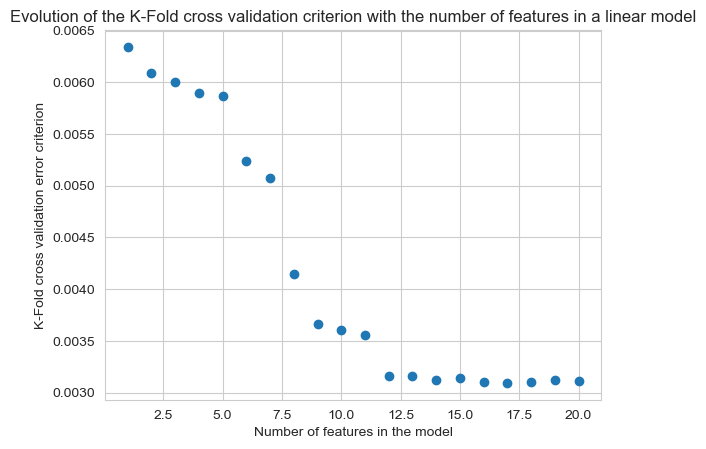

In [284]:
kf = KFold(n_splits=5)

results = np.zeros(20)

for n_features in range(1, 21):
    rmse = 0

    for i, (train_index, val_index) in enumerate(kf.split(X_learn)):

        # We recover the values and the dataframes corresponding to the train set and the validation set
        y_train_kfold, y_val_kfold = y_learn[train_index], y_learn[val_index]
        X_train_kfold_df, X_val_kfold_df = X_learn_df.iloc[train_index], X_learn_df.iloc[val_index]
        y_train_kfold_df, y_val_kfold_df = y_learn_df.iloc[train_index], y_learn_df.iloc[val_index]

        # We then standardize our learning X data (fitting only on the train set but applied to both)
        sc = StandardScaler()
        sc.fit(X_train_kfold_df)
        X_train_kfold = sc.transform(X_train_kfold_df)
        X_val_kfold = sc.transform(X_val_kfold_df)

        # We compute the correlation matrix between the target and the features (based on the train set)
        corr = X_train_kfold_df.corrwith(y_train_kfold_df[0])
        selected_features = [feature for feature in corr.index if abs(corr[feature]) in sorted(abs(corr))[-n_features:]]
        # Finally we fit and evaluate our linear model
        model = LinearRegression()
        model.fit(X_train_kfold_df[selected_features], y_train_kfold)
        predictions = model.predict(X_val_kfold_df[selected_features])
        error = 0
        for idx, prediction in enumerate(predictions):
            error += (prediction - y_val_kfold[idx]) ** 2
        rmse += error / len(val_index)

    rmse = rmse / 5
    results[n_features - 1] = rmse

print(results)
print([i + 1 for i in range(len(results)) if results[i] == min(results)])
plt.figure()
plt.xlabel("Number of features in the model")
plt.ylabel("K-Fold cross validation error criterion")
plt.title("Evolution of the K-Fold cross validation criterion with the number of features in a linear model")
plt.scatter(x=[i for i in range(1, 21)], y=results)
plt.show()

We can see here that the best value is reach for the model which keep 17 features. However we can see on the graph that there is not a significant difference with the model which keep 12 features. To prevent overfitting we will keep only 12 features in the following model.

In [285]:
corr = X_learn_df.corrwith(y_learn_df[0])
print("Here is the correlation of each feature with the target :")
print(corr.abs().sort_values(ascending=False))

selected_features = corr.abs().sort_values(ascending=False)[:12].index

# We then standardize our learning X data (fitting only on the train set but applied to both)
sc = StandardScaler()
sc.fit(X_learn_df[selected_features])
X_learn_linear_model = sc.transform(X_learn_df[selected_features])
X_test_linear_model = sc.transform(X_test_df[selected_features])


def compute_rmse_linear_model(X_learn, y_learn_df, X_test, y_test_df):
    model = LinearRegression()
    model.fit(X_learn, y_learn_df)
    test_predictions = model.predict(X_test)
    rmse_test = 0
    for idx, pred in enumerate(test_predictions):
        rmse_test += (pred - np.array(y_test_df)[idx]) ** 2
    rmse_test = math.sqrt(rmse_test / len(test_predictions))
    return rmse_test


print("The RMSE error for the 12 first correlated features is : ",
      compute_rmse_linear_model(X_learn_linear_model, y_learn_df, X_test_linear_model, y_test_df))

Here is the correlation of each feature with the target :
h5                   0.507559
h4                   0.497927
h8                   0.491637
h3                   0.489798
h6                   0.474317
h1                   0.446324
h7                   0.443933
weight               0.442870
blood pressure       0.426826
cholesterol          0.376362
h2                   0.355641
physical activity    0.346613
age                  0.236439
smurfin donuts       0.209337
testosterone         0.200803
sarsaparilla         0.094112
smurfberry liquor    0.086757
temperature          0.031440
hemoglobin           0.028286
blood type           0.017423
dtype: float64
The RMSE error for the 12 first correlated features is :  0.056321723452808746


We notice that here we use all the image embeddings (so the image bring lots of information). The useless parameters in our model are the temperature, the consumption of smurfberry liquor, the level of hemoglobin and the bloodtype. We don't keep them when we train and test our model.

Now an interesting question is : can we simplify again the model ? Indeed, we know (thanks to our K-fold test) that we will probably decrease our accuracy if we retire the less correlated features. But maybe that removing a more correlated feature which doesn't bring new information can be usefull. For detecting this type of problem, we build a correlation heatmap in order to see the dependencies between the features.

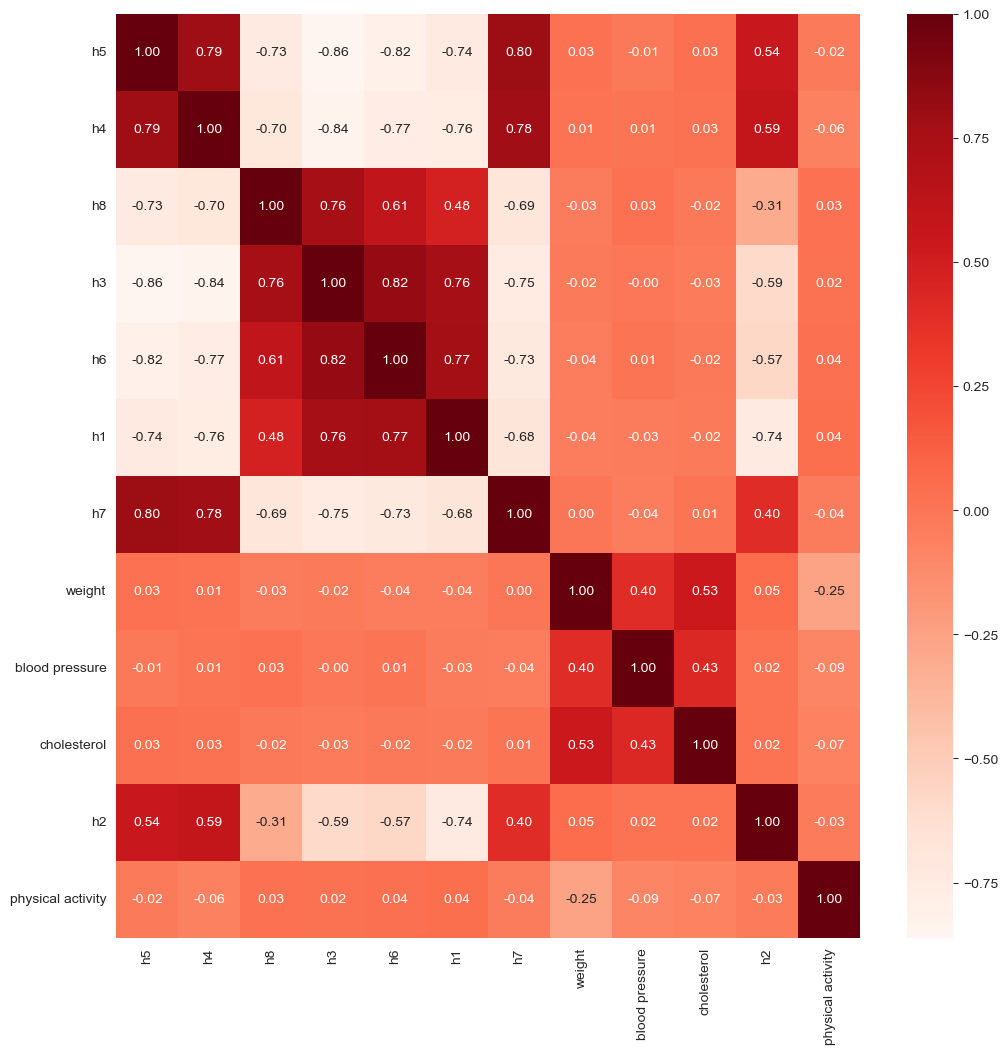

In [286]:
# We analyse the relationships between parameters in order to find redundancy
plt.figure(figsize=(12, 12))
sns.heatmap(X_learn_df[selected_features].corr(), annot=True, fmt=".2f", cmap="Reds")
plt.show()

We see high correlations between the embedding features. Let's try to remove h3 and h7 which are the most correlated ones. Moreover the cholesterol is very correlated to the weight and the blood pressure which are 2 features already selected : let's see if it is a redundant information.

In [287]:
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_learn_df, y_learn_df, test_size=0.20, random_state=13)

selected_features = corr.abs().sort_values(ascending=False)[:12].index.tolist()


def compute_validation_score(selected_features, X_train_df, X_val_df, y_train_df, y_val_df):
    sc = StandardScaler()
    sc.fit(X_train_df[selected_features])
    X_train_all = sc.transform(X_train_df[selected_features])
    X_val_all = sc.transform(X_val_df[selected_features])
    print("Results with : ", selected_features, " = ",
          compute_rmse_linear_model(X_train_all, y_train_df, X_val_all, y_val_df))


# We train the whole model
compute_validation_score(selected_features, X_train_df, X_val_df, y_train_df, y_val_df)
# And then test to remove some high correlated features
selected_features.remove("h3")
compute_validation_score(selected_features, X_train_df, X_val_df, y_train_df, y_val_df)
selected_features.remove("h7")
compute_validation_score(selected_features, X_train_df, X_val_df, y_train_df, y_val_df)
# Try to remove weight
selected_features.remove("cholesterol")
compute_validation_score(selected_features, X_train_df, X_val_df, y_train_df, y_val_df)

Results with :  ['h5', 'h4', 'h8', 'h3', 'h6', 'h1', 'h7', 'weight', 'blood pressure', 'cholesterol', 'h2', 'physical activity']  =  0.054363523277576174
Results with :  ['h5', 'h4', 'h8', 'h6', 'h1', 'h7', 'weight', 'blood pressure', 'cholesterol', 'h2', 'physical activity']  =  0.0538681667519005
Results with :  ['h5', 'h4', 'h8', 'h6', 'h1', 'weight', 'blood pressure', 'cholesterol', 'h2', 'physical activity']  =  0.053578944006441385
Results with :  ['h5', 'h4', 'h8', 'h6', 'h1', 'weight', 'blood pressure', 'h2', 'physical activity']  =  0.05350201701666547


We can remove h3, h7 and the cholesterol level with a gain on this validation set (in this precise case). It is logical given the previous heatmap matrix. We will remove them from our model and train it again. To sum up we keep 6 embeddings from the image, the weight, the blood pressure and the physical activity. This seems coherent with real significant features for heart diseases.

In [288]:
selected_features = corr.abs().sort_values(ascending=False)[:12].index.tolist()
selected_features.remove("h3")
selected_features.remove("h7")
selected_features.remove("cholesterol")

sc = StandardScaler()
sc.fit(X_learn_df[selected_features])
X_learn_final_linear_model = sc.transform(X_learn_df[selected_features])
X_test_final_linear_model = sc.transform(X_test_df[selected_features])

print(compute_rmse_linear_model(X_learn_final_linear_model, y_learn_df, X_test_final_linear_model, y_test_df))

0.05750468555055509


If we compare this new value to the previous one obtained on the test set we can see that even if it is a greater value, both are very similar and we have simplified the model a lot. So the result is quite positive. 

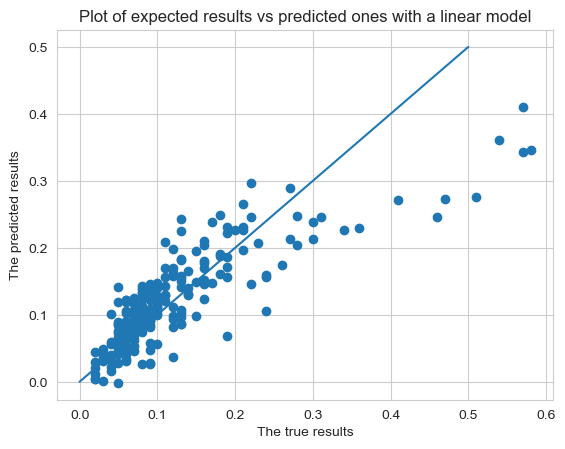

In [289]:
# We plot the True results vs the predicted one

x = np.linspace(0, 0.5, 100)
true_results = y_test
model = LinearRegression()
model.fit(X_learn_final_linear_model, y_learn_df)
test_predictions = model.predict(X_test_final_linear_model)
plt.scatter(true_results, test_predictions)
plt.plot(x, x)
plt.xlabel("The true results")
plt.ylabel("The predicted results")
plt.title("Plot of expected results vs predicted ones with a linear model")
plt.show()


#### Interpretation of the results for linear model

We can see that the results are rather well approximated for low chances of developping a disease but the probability are largely underestimated for high values. This is probably because the data are not linearly dependent. This can be dangerous for a real utilisation because we take the risk of not detecting some diseases. 

We can interpret this value as the mean error made on our probability (between 0 and 1) to develop a heart disease.
    
Feature selection before or after hyperparameters or a part before and a part after.

# A Multilinear Perceptron

We try to train a multilinear perceptron (MLP) in this part of the project.

There are several hyperparameters in a MLP model. We can choose the number of layers, the number of neuron for each layer, the activation function, the number of training steps... But we have to find the set of features that we will use here first. Indeed we are now able to work on the non linear dependencies so we will now use a filter selection based on mutual information. It is convenient to find the best features before research of hyperparameters given that it is a model free method. Then let's use the GridSearch method for choosing the best hyperparameters.

We have to fix the selected features before choosing our hyperparameters or on the contrary we have to fix the hyperparameters before choosing our features. We can obviously not test all the combinations between hyperparameters and features. That's why we choose here to select globally some features here which will be kept for all the next models. Then we will select our hyperparameters according to these features. Finally for each model and its hyperparameters (which are now fixed) we will look at the less significant features and remove some of them if possible.  

[0.0, 0.0, 0.007990109770548148, 0.01640485501083111, 0.019730570765178257, 0.025592268214658542, 0.033957649170695436, 0.04563355582040485, 0.06301603401989375, 0.07357416711202358, 0.10312642313820808, 0.11186683540701825, 0.1142175991513783, 0.14828765430308488, 0.1721291458435048, 0.2034813224743215, 0.20696194404538337, 0.20697578718606957, 0.21144407649044483, 0.21295412435170746]


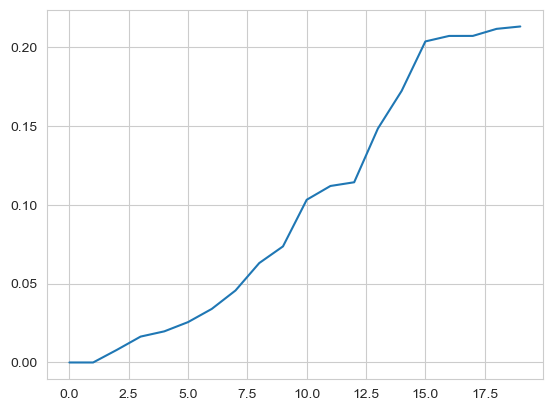

['blood pressure', 'physical activity', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8']
10


In [290]:
# mutual information between each feature and the target
mi = pd.Series(mutual_info(X_learn_df.values, y_learn_df.values.ravel()), index=X_learn_df.columns)
print(sorted(mi))

plt.figure()
plt.plot(sorted(mi))
plt.show()

# selection of the best features (according this criterion)
#selected_features =  [feature for feature in mi.index if mi[feature] > 0.1] 
selected_features = [feature for feature in mi.index if mi[feature] in sorted(mi)[-10:]]
print(selected_features)
print(len(selected_features))

The results of the mutual information are not determinist. That is the reason why the observed result are not always the same. However the $10$ best parameters stay the same (with different values of mutual information according to the execution).Their mutual information is very often greater than $0.1$ and there is often a little gap with the $11th$ value of mutual information. This is the reason why we will keep these 10 features : the image embeddings, the blood pressure and the physical activity. We can highlight the fact that these features were already very significant for the linear model.

In [291]:
# Compute the Root Mean Square Error
def compute_rmse(predict, target):
    if not isinstance(predict, np.ndarray):
        predict = np.array(predict)
    if not isinstance(target, np.ndarray):
        target = np.array(target)
    # rmse = 0
    # for p, t in zip(predict, target):
    #     rmse += (t - p) ** 2
    # rmse = np.sqrt(((predict - target) ** 2).sum() / predict.size)
    rmse = np.sqrt(np.mean((predict - target) ** 2))
    return rmse


# Search of the hyperparameters
def perform_grid_search(model, param_grid, score_function, kf, X, y):
    score = make_scorer(score_function, greater_is_better=False)
    grid = GridSearchCV(model, param_grid, cv=kf, scoring=score)
    grid.fit(X, y)
    return grid


# We scale the data and we prepare the grid research

sc = StandardScaler()
sc.fit(X_learn_df[selected_features])
X_learn_mlp = sc.transform(X_learn_df[selected_features])
X_test_mlp = sc.transform(X_test_df[selected_features])

param_grid = {"hidden_layer_sizes": [(32, 32), (64, 64), (128, 128), (264, 264)],
              "learning_rate": ["adaptive"],
              "learning_rate_init": [0.005, 0.01, 0.05, 0.1],
              "max_iter": [64, 128, 256, 512],
              "activation": ["relu", "tanh", "logistic"]}

mlp = MLPRegressor()

grid = perform_grid_search(mlp, param_grid, compute_rmse, KFold(5), X_learn_mlp, y_learn.ravel())

print(grid.best_params_)

D:\Anaconda\envs\czh\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\czh\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\czh\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (128) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\czh\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (128) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\envs\czh\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:69

{'activation': 'relu', 'hidden_layer_sizes': (264, 264), 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'max_iter': 256}


0.05572170326020641


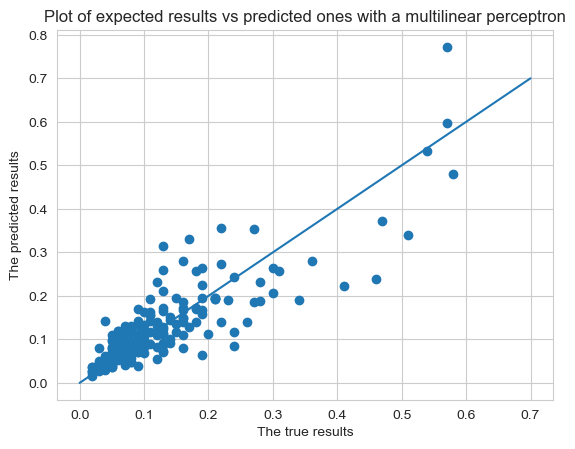

In [292]:
# evaluation on test set
y_pred_test = grid.predict(X_test_mlp)
rmse_test = compute_rmse(y_pred_test, y_test.ravel())
print(rmse_test)

# plot of true values vs expected values
x = np.linspace(0, 0.7, 100)
true_results = y_test
plt.scatter(true_results, y_pred_test)
plt.plot(x, x)
plt.xlabel("The true results")
plt.ylabel("The predicted results")
plt.title("Plot of expected results vs predicted ones with a multilinear perceptron")
plt.show()

We can see that the results are a little bit better than for the linear model. Firstly the rmse is a little bit smaller here ($0.055$ vs $0.058$) and we don't always have the problem of underestimating high probabilities. The tendency is still present but some values are now also overestimated or very close to their exact value (so in average it is better).

# K Nearest-Neighbors

We will now implement a K Nearest Neighbors classifier. Here we have also several hyperparameters to fix : the distance, the type of computation to do with the k nearest neighbors (e.g. the average) and the number of neighbors. We will arbitrarly fix the computation to an average of the nearest neighbor components. It is the most common way to use a k-nn classifier and it is simplier to use. So our main goal here will be to fix the value of k and the metric, in other words the number of neighbors to average for predicting the target of a new observation and how to measure the distance between neighbors.

As the wrapper method relies on the model performance which is to some degree determined by the chosen hyperparameters, we firstly determine the best hypeparameters by the set of features obtained by mutual information and then choose the features that are effective for KNN model.

In [293]:
##################################
### Choice of the hyperparameter k
##################################

# Scaling of the data
sc = StandardScaler()
# sc.fit(X_learn_df)
# X_learn_knn = sc.transform(X_learn_df)
# X_test_knn = sc.transform(X_test_df)
sc.fit(X_learn_df[selected_features])
X_learn_knn = sc.transform(X_learn_df[selected_features])
X_test_knn = sc.transform(X_test_df[selected_features])

X_learn_knn = pd.DataFrame(X_learn_knn, columns=selected_features)
X_test_knn = pd.DataFrame(X_test_knn, columns=selected_features)

# Tuning of hyperparameter k

param_grid = {"n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
              "metric": ["manhattan", "euclidean", "chebyshev"]}

knn = KNeighborsRegressor()

grid = perform_grid_search(knn, param_grid, compute_rmse, KFold(n_splits=5), X_learn_knn,
                           y_learn.ravel())

print(grid.best_params_)

print(-1 * grid.best_score_)



{'metric': 'chebyshev', 'n_neighbors': 6}
0.05781656468469709


Now we have got the best hyperparameters determined by the set of features selected above, we use **wrapper** method to do feature selection. Note: we consider the nb of features as a hyperparameter as well.

In [294]:
# Determine the nb of features and features
# model = KNeighborsRegressor(n_neighbors=grid.best_params_["n_neighbors"], metric=grid.best_params_["metric"])
model = grid.best_estimator_
# record the rmse with different size of set of features
rmses = {10: -1 * grid.best_score_}
selected_feature_names = {10: selected_features}
# K-fold
kf = KFold(n_splits=5)
for n_features in range(len(selected_features) - 1, 0, -1):
    rmses_temp = 0
    for i, (train_index, val_index) in enumerate(kf.split(X_learn_knn)):
        X_train_df_knn, y_train_knn = X_learn_knn.iloc[train_index], y_learn[train_index]
        X_val_df_knn, y_val_knn = X_learn_knn.iloc[val_index], y_learn[val_index]
        # use wrapper to choose features
        score = make_scorer(compute_rmse, greater_is_better=False)
        sfs = SequentialFeatureSelector(model, direction="backward", n_features_to_select=n_features, scoring=score)
        sfs.fit(X_train_df_knn, y_train_knn)
        feature_names = sfs.get_feature_names_out()
        # evaluate the model performance on the temp set of features
        X_train_knn_temp = X_train_df_knn[feature_names]
        X_val_knn_temp = X_val_df_knn[feature_names]

        model.fit(X_train_knn_temp, y_train_knn)
        predict_temp = model.predict(X_val_knn_temp)
        rmse_temp = compute_rmse(predict_temp, y_val_knn)

        rmses_temp += rmse_temp

    rmses[n_features] = rmses_temp * (1 / 5)
best_nb_features = sorted(rmses, key=rmses.get, reverse=False)[0]
best_nb_features

10

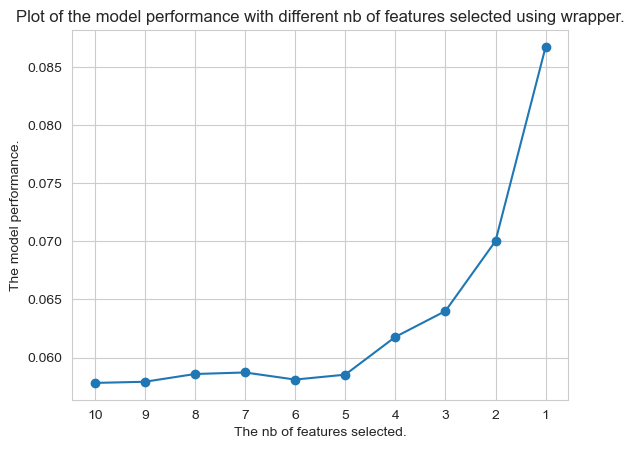

In [295]:
# plot the model performance with different size of set of features
plt.plot(rmses.values(), "o-")
# plt.annotate(rmses.values(), zip(np.arange(len(rmses.keys())), rmses.values()))
plt.xticks(np.arange(len(rmses.keys())), rmses.keys())
plt.xlabel("The nb of features selected.")
plt.ylabel("The model performance.")
plt.title("Plot of the model performance with different nb of features selected using wrapper.")
plt.show()

As shown in the figure above, although the loss function value of 10 features is the least, that of 6 features doesn't drop significantly (in fact, less than 1%). Furthermore, the sparsity in high-dimensional space will reduce its performance. Thus, we then firstly determine the fixed feature set and consequently search for the best hyperparameters.

In [296]:
# Fixed feature set
sfs = SequentialFeatureSelector(model, direction="backward", n_features_to_select=6)
sfs.fit(X_learn_knn, y_learn)
feature_names = sfs.get_feature_names_out()
feature_names

array(['blood pressure', 'physical activity', 'h2', 'h4', 'h5', 'h8'],
      dtype=object)

The particular features haven been obtained by a backward wrapper. Further, the specific features are *blood pressure*, *physical activity* and *h2*, *h4*, *h5* and *h8* of the image embedding.

In [297]:
# Determine the best hyperparameters
best_knn = KNeighborsRegressor(n_neighbors=grid.best_params_['n_neighbors'], metric=grid.best_params_['metric'])
best_knn.fit(X_learn_knn[feature_names], y_learn.ravel())

KNeighborsRegressor(metric='chebyshev', n_neighbors=6)

0.06661320773273453


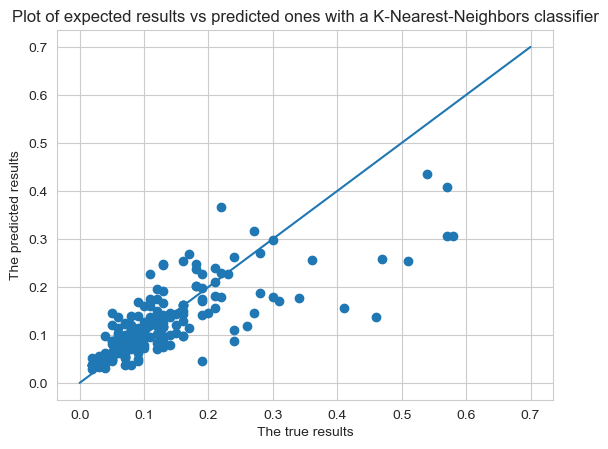

In [298]:
# Prediction of new values
predictions_knn = best_knn.predict(X_test_knn[feature_names])
rmse_knn = compute_rmse(predictions_knn, y_test.ravel())
print(rmse_knn)

# plot of true values vs expected values
x = np.linspace(0, 0.7, 100)
true_results = y_test
plt.scatter(true_results, predictions_knn)
plt.plot(x, x)
plt.xlabel("The true results")
plt.ylabel("The predicted results")
plt.title("Plot of expected results vs predicted ones with a K-Nearest-Neighbors classifier")
plt.show()

As reported in the block above, the RMSE obtained on test set, namely 0.067, is a little bit larger than those of the former two models. Although K-NN is way simpler, it only archives data points in a specific feature space instead of learning the differences of the distributions of different categories. Furthermore, K-NN may not perform well when the dimension of the feature space is too large because of the sparsity.

# Support Vector Regression

Till now, we have not visualized the data in a low dimension space. We present the visualization in 2D space using one of the most powerful dimension reduction technique, t-SNE.

In [299]:
def vis(comp, y):
    fig, ax = plt.subplots()
    comp1 = comp[:, 0]
    comp2 = comp[:, 1]
    cmap = plt.cm.RdPu(1-y)
    n_classes = len(y)
    classes = list(y)
    ax.scatter(comp1, comp2, s=10, c=cmap)
    # plt.xlabel("Principal Component 1")
    # plt.ylabel("Principal Component 2")
    plt.xlabel("X_LD")
    plt.ylabel("Y_LD")
    plt.legend()
    plt.show()

In [300]:
# visualization through t-SNE
tsne = TSNE(n_components=2, perplexity=100, metric='cosine')
ld_xy = tsne.fit_transform(X_learn)

pca = PCA(n_components=2)
y = pca.fit_transform(X_learn)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


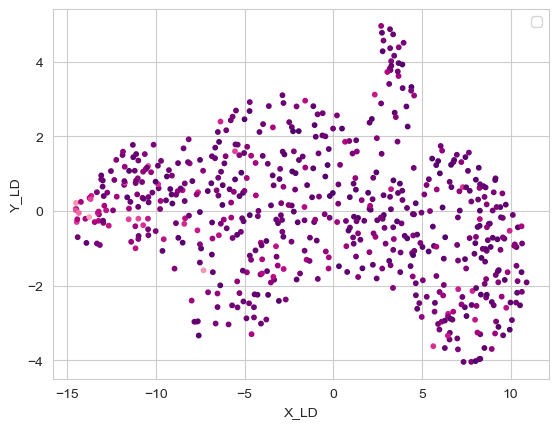

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


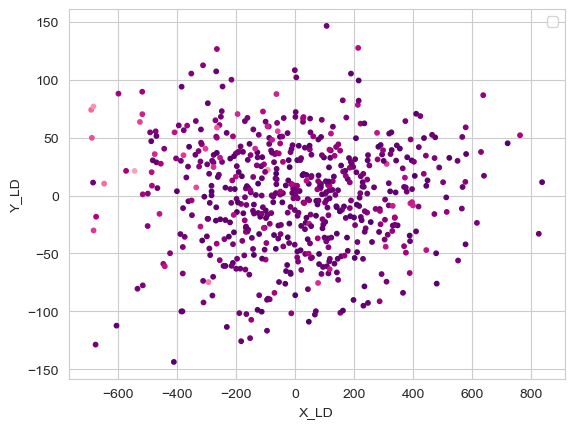

In [301]:
vis(ld_xy, y_learn)
vis(y, y_learn)

Support Vector Machine performs well on tasks on small data sets. The *soft classification* improves the robustness of this algorithm. However, the binary-classification model may not fit our numeric labels as we expect. Therefore, we choose to approximate a linear regression model with the help of support vectors using Support Vector Regression.

In [311]:
# Support Vector Regression
# tuning hyperparameters
sc = StandardScaler()
sc.fit(X_learn_df[selected_features])
X_learn_svr = sc.transform(X_learn_df[selected_features])
X_test_svr = sc.transform(X_test_df[selected_features])

X_learn_svr = pd.DataFrame(X_learn_svr, columns=selected_features)
X_test_svr = pd.DataFrame(X_test_svr, columns=selected_features)

svr = SVR()
param_grid_svr = {"C": [0.2, 0.4, 0.6, 0.8, 1, 1.5, 2, 5, 10, 15, 20, 25, 30, 50, 100],
                  "kernel": ["linear", "rbf", "sigmoid", "poly"],
                  "epsilon": np.linspace(0, 1, 10)}
grid = perform_grid_search(svr, param_grid_svr, compute_rmse, KFold(n_splits=3), X_learn_svr,
                           y_learn.ravel())
print(grid.best_params_)
print(-1 * grid.best_score_)

{'C': 0.2, 'epsilon': 0.0, 'kernel': 'rbf'}
0.056983064582686316


We aim to investigate three primary hyperparameters of SVR, namely the penalty coefficient *C*, tolerance for prediction errors *$\epsilon$* and kernel function where sigmoid, polynomial and redial basis function are mostly used ones, respectively. As shown in the printed results, the best $\epsilon$ is **0** which means the best SVR in our case doesn't take the tolerance of prediction error into consideration. Moreover, the best kernel function used is redial basis function according to the cross-validation grid search result, which indicates that the regression is approximated in an implicit embedding space. In all, the optimized objective function of our best model chosen is :$\min\sum_{\omega,b}\frac{1}{2}||\omega||^2+(\omega^Tx+b-y)$.

In [312]:
# record the rmse with different size of set of features
rmses = {10: -1 * grid.best_score_}
selected_feature_names = {10: selected_features}
# K-fold
kf = KFold(n_splits=3)
for n_features in range(len(selected_features) - 1, 0, -1):
    rmses_temp = 0
    for i, (train_index, val_index) in enumerate(kf.split(X_learn_svr)):
        X_train_df_svr, y_train_svr = X_learn_svr.iloc[train_index], y_learn[train_index]
        X_val_df_svr, y_val_svr = X_learn_svr.iloc[val_index], y_learn[val_index]
        model = SVR(kernel=grid.best_params_["kernel"], C=grid.best_params_["C"],epsilon=grid.best_params_["epsilon"])
        # use wrapper to choose features
        score = make_scorer(compute_rmse, greater_is_better=False)
        sfs = SequentialFeatureSelector(model, direction="backward", n_features_to_select=n_features, scoring=score)
        sfs.fit(X_train_df_svr, y_train_svr.ravel())
        feature_names = sfs.get_feature_names_out()
        # evaluate the model performance on the temp set of features
        X_train_svr_temp = X_train_df_svr[feature_names]
        X_val_svr_temp = X_val_df_svr[feature_names]

        # define hyperparameters
        # model = SVR(kernel=grid.best_params_["kernel"], C=grid.best_params_["C"])
        model.fit(X_train_svr_temp, y_train_svr.ravel())
        predict_temp = model.predict(X_val_svr_temp)
        rmse_temp = compute_rmse(predict_temp, y_val_svr.ravel())

        rmses_temp += rmse_temp

    rmses[n_features] = rmses_temp * (1 / 3)
    # selected_feature_names[n_features] = feature_names
best_nb_features = sorted(rmses, key=rmses.get, reverse=False)[0]
best_nb_features

9

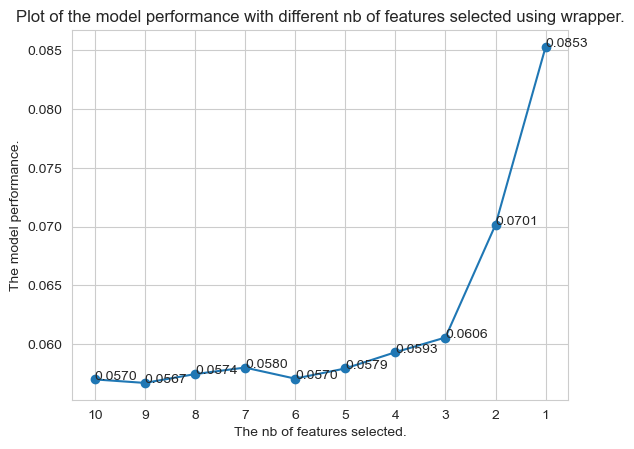

In [331]:
plt.plot(rmses.values(), "o-")
plt.xticks(np.arange(len(rmses.keys())), rmses.keys())
plt.xlabel("The nb of features selected.")
plt.ylabel("The model performance.")
plt.title("Plot of the model performance with different nb of features selected using wrapper.")
for i, j in zip(np.arange(len(rmses.keys())), np.array(list(rmses.values()))):
    plt.annotate(f"{list(rmses.values())[i]:.4f}", xy=(i, j))
plt.show()

As shown in the figure above, although the loss function value of 9 features is the least, that of 6 features doesn't drop significantly (in fact, less than 1%). Thus, in order to avoid overfitting further, we then determine the number of features to be 6.

In [317]:
# select the best n_features features
best_nb_features = 6
score = make_scorer(compute_rmse, greater_is_better=False)
sfs = SequentialFeatureSelector(grid.best_estimator_, n_features_to_select=best_nb_features, direction="backward",
                                scoring=score)
sfs.fit(X_learn_svr, y_learn.ravel())
feature_names = sfs.get_feature_names_out()
feature_names

array(['blood pressure', 'physical activity', 'h1', 'h3', 'h7', 'h8'],
      dtype=object)

As shown in the block above, the features that significantly contribute to prediction are *blood pressure*, *physical activity* and *h1*, *h3*, *h7* and *h8* of heart image embedding, which are not the same as those of K-NN model.

In [318]:
# best_nb_features = 10
best_svr = SVR(kernel=grid.best_params_["kernel"], C=grid.best_params_["C"], epsilon=grid.best_params_["epsilon"])
# feature_names = selected_feature_names[best_nb_features]
# Prediction of new values
best_svr.fit(X_learn_svr[feature_names], y_learn.ravel())
predictions_svr = best_svr.predict(X_test_svr[feature_names])
rmse_svr = compute_rmse(predictions_svr, y_test.ravel())
print(rmse_svr)
feature_names

0.06168602280097981


array(['blood pressure', 'physical activity', 'h1', 'h3', 'h7', 'h8'],
      dtype=object)

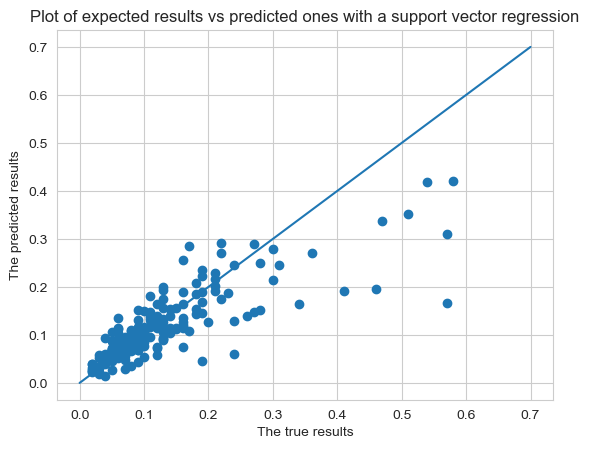

In [319]:
# plot of true values vs expected values
x = np.linspace(0, 0.7, 100)
true_results = y_test
plt.scatter(true_results, predictions_svr)
plt.plot(x, x)
plt.xlabel("The true results")
plt.ylabel("The predicted results")
plt.title("Plot of expected results vs predicted ones with a support vector regression")
plt.show()

As we have discussed above, the Support Vector Regression model degenerates into a general linear regression, but in an implicit embedding space of redial basis function. Thus, all the vectors become the support vectors. To boost the performance when predicting, the hyperparameter $\epsilon$ could be tuned to improve the robustness.